In [1]:
from __future__ import print_function, division

%matplotlib inline
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['figure.figsize'] = (10,6)
from matplotlib import pyplot as plt
import seaborn as sns; sns.set(context="poster")
import ipywidgets
import yt

import glob
import os
import sys
import warnings
import h5py

import numpy as np
import pandas as pd

from units import M_solar, m_proton, pc, yr, Myr, km, s, gamma

from injection_helpers import get_SNe

from visualize_helpers import \
    get_snapshot_filenames, \
    snapshot_filename_to_number, \
    total_mass_of_snapshot, \
    total_radial_momentum_of_snapshot, \
    map_to_all_snapshots, \
    get_snapshot_times, \
    total_kinetic_energy_of_snapshot, \
    total_internal_energy_of_snapshot, \
    load_snapshots, \
    plot_projected_density, \
    plot_sliced_field, \
    plot_phase_diagram, \
    field_type, \
    plot_profile, \
    yt_plot_saver, \
    mpl_plot_saver, \
    load_ds_from_ts

import MHD
    
from sql_helpers import add_simulation, \
    open_as_DataFrame

%load_ext autoreload
%autoreload 2

/pfs/home/egentry/anaconda3/envs/py36/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/pfs/home/egentry/anaconda3/envs/py36/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/pfs/home/egentry/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


`grackle_helpers.wrapped_initializer` is setting up grackle assuming code units:
    mass   : 1.0 M_solar
    length : 1.0 pc
    time   : 1.0 Myr

grackle cooling file:  b'/pfs/home/egentry/local/grackle/input/CloudyData_UVB=HM2012.h5'
`grackle_helpers.wrapped_initializer` is setting up grackle assuming code units:
    mass   : 8.41e-58 M_solar
    length : 3.24e-19 pc
    time   : 3.17e-14 Myr

grackle cooling file:  b'/pfs/home/egentry/local/grackle/input/CloudyData_UVB=HM2012.h5'


In [2]:
# run_name = "cluster_cooling_100"
# run_name = "cluster_cooling_100-perturbed"
# run_name = "cluster_cooling_100-small_steps"
# run_name = "cluster_cooling_mhd_100"
# run_name = "cluster_cooling_133"
run_name = "cluster_cooling_200"
# run_name = "cluster_cooling_200-perturbed"
# run_name = "cluster_cooling_200-quantify_distributions"
# run_name = "cluster_cooling_200-small_steps"
# run_name = "cluster_cooling_200-small_steps-early"
# run_name = "cluster_cooling_mhd_200"
# run_name = "cluster_cooling_mhd_small_200"
# run_name = "cluster_cooling_mhd_large_200"
# run_name = "cluster_cooling_mhd_large_200-small_steps"
# run_name = "cluster_cooling_mhd_large_200-small_steps-early"
# run_name = "cluster_cooling_300"
# run_name = "cluster_cooling_400"
# run_name = "cluster_cooling_400-perturbed"
# run_name = "cluster_cooling_400-small_steps"
# run_name = "cluster_cooling_600"
# run_name = "single"
# run_name = "single_cooling"
# run_name = "double"
# run_name = "double_cooling"

run_dir = os.path.join(os.path.pardir, "runs", run_name)

inputs_dir  = os.path.join(run_dir, "inputs")
outputs_dir = os.path.join(run_dir, "outputs")

plots_dir = os.path.join(outputs_dir, "plots")
if not os.path.exists(plots_dir):
    print("making plots_dir")
    os.mkdir(plots_dir)

In [3]:
save_plots = True

# Update / Load Database

In [4]:
add_simulation(run_name, verbose=True)

df = open_as_DataFrame(run_name)
df.tail()

adding:  ../runs/cluster_cooling_200/outputs/snapshot_000.hdf5
Snapshot #0 already found for run: cluster_cooling_200
adding:  ../runs/cluster_cooling_200/outputs/snapshot_001.hdf5
Snapshot #1 already found for run: cluster_cooling_200
adding:  ../runs/cluster_cooling_200/outputs/snapshot_002.hdf5
Snapshot #2 already found for run: cluster_cooling_200
adding:  ../runs/cluster_cooling_200/outputs/snapshot_003.hdf5
Snapshot #3 already found for run: cluster_cooling_200
adding:  ../runs/cluster_cooling_200/outputs/snapshot_004.hdf5
Snapshot #4 already found for run: cluster_cooling_200
adding:  ../runs/cluster_cooling_200/outputs/snapshot_005.hdf5
Snapshot #5 already found for run: cluster_cooling_200
adding:  ../runs/cluster_cooling_200/outputs/snapshot_006.hdf5
Snapshot #6 already found for run: cluster_cooling_200
adding:  ../runs/cluster_cooling_200/outputs/snapshot_007.hdf5
Snapshot #7 already found for run: cluster_cooling_200
adding:  ../runs/cluster_cooling_200/outputs/snapshot_00

,number,time,e_kin,e_int,e_mag,mass,momentum,run_name
110,110,38.442815,5.127027e+49,4.839033e+50,0.0,7.097510e+06,4.489051e+44,cluster_cooling_200
111,111,38.961543,5.094361e+49,4.847882e+50,0.0,7.097510e+06,4.479237e+44,cluster_cooling_200
112,112,39.480272,5.061391e+49,4.856718e+50,0.0,7.097510e+06,4.469928e+44,cluster_cooling_200
113,113,39.999000,5.027351e+49,4.865517e+50,0.0,7.097510e+06,4.461177e+44,cluster_cooling_200
114,114,39.999000,5.027185e+49,4.865599e+50,0.0,7.097510e+06,4.461122e+44,cluster_cooling_200


# Overview

In [5]:
ts = load_snapshots(outputs_dir)
snapshot_filenames = get_snapshot_filenames(outputs_dir)

snapshot_number_to_index_map = {snapshot_filename_to_number(filename) : i
                                for i,filename in enumerate(snapshot_filenames) }

uncompressed_snapshot_numbers = sorted(list(snapshot_number_to_index_map.keys()))

times_snapshots = df.time

print("Loaded {} uncompressed snapshots".format(len(ts)))

ds = load_ds_from_ts(ts, 0)
rho_0 = None

# if rho_0 is None:
#     rho_0 = load_ds_from_ts(ts, 0).all_data()["all","density"].mean()

Loaded 115 uncompressed snapshots


yt : [INFO     ] 2018-08-25 11:31:56,478 Omega Lambda is 0.0, so we are turning off Cosmology.
yt : [INFO     ] 2018-08-25 11:31:56,563 Parameters: current_time              = 0.0
yt : [INFO     ] 2018-08-25 11:31:56,566 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2018-08-25 11:31:56,568 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2018-08-25 11:31:56,571 Parameters: domain_right_edge         = [600. 600. 600.]
yt : [INFO     ] 2018-08-25 11:31:56,573 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2018-08-25 11:31:56,584 Allocating for 2.700e+07 particles (index particle type 'all')
yt : [INFO     ] 2018-08-25 11:32:08,450 Identified 2.364e+06 octs
/pfs/home/egentry/anaconda3/envs/py36/lib/python3.6/site-packages/yt/units/yt_array.py:978: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[

In [6]:
times_snapshots

0       0.000000
1       0.001000
2       0.127017
3       0.253034
4       0.379051
5       0.505068
6       0.631085
7       0.633085
8       1.014899
9       1.396712
10      1.778526
11      2.160339
12      2.542153
13      2.544153
14      2.663841
15      2.783530
16      2.903218
17      3.022906
18      3.142595
19      3.144595
20      3.289131
21      3.433668
22      3.578205
23      3.722742
24      3.867279
25      3.867279
26      3.869279
27      4.387625
28      4.905972
29      5.424318
         ...    
85     27.162264
86     27.446806
87     27.731349
88     28.015891
89     28.300434
90     28.584976
91     28.586976
92     29.105704
93     29.624433
94     30.143161
95     30.661890
96     31.180618
97     31.699346
98     32.218075
99     32.736803
100    33.255531
101    33.774260
102    34.292988
103    34.811716
104    35.330445
105    35.849173
106    36.367901
107    36.886630
108    37.405358
109    37.924087
110    38.442815
111    38.961543
112    39.4802

In [7]:
print( "Length unit: ",   ds.length_unit)
print( "Time unit: ",     ds.time_unit)
print( "Mass unit: ",     ds.mass_unit)
print( "Velocity unit: ", ds.velocity_unit)

Length unit:  0.001000000000163616 kpc
Time unit:  31557600000000.0 s
Mass unit:  1.0000299511482191 Msun
Velocity unit:  97779.22216731282 cm/s


# What fields do I have access to?

In [8]:
# ds.add_particle_filter("overdense")

In [9]:
dd = ds.all_data()

In [10]:
ds.field_list

[('PartType0', 'Coordinates'),
 ('PartType0', 'Density'),
 ('PartType0', 'ElectronAbundance'),
 ('PartType0', 'InternalEnergy'),
 ('PartType0', 'Masses'),
 ('PartType0', 'Metallicity'),
 ('PartType0', 'NeutralHydrogenAbundance'),
 ('PartType0', 'ParticleChildIDsNumber'),
 ('PartType0', 'ParticleIDGenerationNumber'),
 ('PartType0', 'ParticleIDs'),
 ('PartType0', 'SmoothingLength'),
 ('PartType0', 'Velocities'),
 ('all', 'Coordinates'),
 ('all', 'Density'),
 ('all', 'ElectronAbundance'),
 ('all', 'InternalEnergy'),
 ('all', 'Masses'),
 ('all', 'Metallicity'),
 ('all', 'NeutralHydrogenAbundance'),
 ('all', 'ParticleChildIDsNumber'),
 ('all', 'ParticleIDGenerationNumber'),
 ('all', 'ParticleIDs'),
 ('all', 'SmoothingLength'),
 ('all', 'Velocities')]

In [11]:
ds.derived_field_list

[('PartType0', 'Coordinates'),
 ('PartType0', 'Density'),
 ('PartType0', 'ElectronAbundance'),
 ('PartType0', 'H_nuclei_density'),
 ('PartType0', 'He_nuclei_density'),
 ('PartType0', 'InternalEnergy'),
 ('PartType0', 'Masses'),
 ('PartType0', 'Metallicity'),
 ('PartType0', 'NeutralHydrogenAbundance'),
 ('PartType0', 'ParticleChildIDsNumber'),
 ('PartType0', 'ParticleIDGenerationNumber'),
 ('PartType0', 'ParticleIDs'),
 ('PartType0', 'SmoothingLength'),
 ('PartType0', 'Temperature'),
 ('PartType0', 'Velocities'),
 ('PartType0', 'density'),
 ('PartType0', 'mesh_id'),
 ('PartType0', 'metallicity'),
 ('PartType0', 'particle_angular_momentum'),
 ('PartType0', 'particle_angular_momentum_magnitude'),
 ('PartType0', 'particle_angular_momentum_x'),
 ('PartType0', 'particle_angular_momentum_y'),
 ('PartType0', 'particle_angular_momentum_z'),
 ('PartType0', 'particle_cylindrical_velocity_theta'),
 ('PartType0', 'particle_cylindrical_velocity_z'),
 ('PartType0', 'particle_index'),
 ('PartType0', '

# Extract R_shock, V_shock

In [12]:
def E_dot_total(i_snapshot):
    
    ds = load_ds_from_ts(ts, snapshot_number_to_index_map[i_snapshot])
    dd = ds.all_data()
    
    E_dot = float(np.sum(dd["affected", "cooling_rate"]).to("erg / Myr").value)
    
    return E_dot

In [35]:
%%time 
E_dot = E_dot_total(100)
print(E_dot)


yt : [INFO     ] 2018-08-12 18:29:43,801 Omega Lambda is 0.0, so we are turning off Cosmology.
yt : [INFO     ] 2018-08-12 18:29:43,851 Parameters: current_time              = 33.25553131812538
yt : [INFO     ] 2018-08-12 18:29:43,853 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2018-08-12 18:29:43,856 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2018-08-12 18:29:43,859 Parameters: domain_right_edge         = [600. 600. 600.]
yt : [INFO     ] 2018-08-12 18:29:43,862 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2018-08-12 18:29:43,873 Allocating for 2.700e+07 particles (index particle type 'all')
yt : [INFO     ] 2018-08-12 18:29:48,316 Identified 2.132e+06 octs


1.3294181290379891e+48
CPU times: user 2min 17s, sys: 10 s, total: 2min 27s
Wall time: 2min 27s


In [13]:
outfile = "shock_model_2pc - Edot - numeric.csv"


In [14]:
if os.path.exists(outfile):
    df_shock = pd.read_csv(outfile)
    
else:
    df_shock = pd.DataFrame(
        data={
            "i_snapshot": np.empty(0, dtype=int),
            "E_dot": np.empty(0, dtype=float),
        }
    )

for i_snapshot in df.number:
    if i_snapshot in df_shock.i_snapshot:
        print("already read snapshot {}; skipping to next".format(i_snapshot))
        continue
        
    E_dot = E_dot_total(i_snapshot)
    _df_shock = pd.DataFrame(
        data={
            "i_snapshot": np.array([i_snapshot], dtype=int),
            "E_dot": np.array([E_dot], dtype=float),
    })

    df_shock = pd.concat([df_shock, _df_shock], ignore_index=True)
    df_shock = df_shock[["i_snapshot", "E_dot"]]

    df_shock.to_csv(outfile, index=False)
    print("finished reading snapshot ", i_snapshot)
    sys.stdout.flush()

df_shock.to_csv(outfile, index=False)
    

already read snapshot 0; skipping to next
already read snapshot 1; skipping to next
already read snapshot 2; skipping to next
already read snapshot 3; skipping to next
already read snapshot 4; skipping to next
already read snapshot 5; skipping to next
already read snapshot 6; skipping to next
already read snapshot 7; skipping to next
already read snapshot 8; skipping to next
already read snapshot 9; skipping to next
already read snapshot 10; skipping to next
already read snapshot 11; skipping to next
already read snapshot 12; skipping to next
already read snapshot 13; skipping to next
already read snapshot 14; skipping to next
already read snapshot 15; skipping to next
already read snapshot 16; skipping to next
already read snapshot 17; skipping to next
already read snapshot 18; skipping to next
already read snapshot 19; skipping to next
already read snapshot 20; skipping to next
already read snapshot 21; skipping to next
already read snapshot 22; skipping to next
already read snapshot

In [15]:
df_shock.head()

,i_snapshot,E_dot
0,0,0.000000e+00
1,1,0.000000e+00
2,2,1.172874e+51
3,3,4.021156e+50
4,4,2.280714e+50


In [17]:
_df = df_shock.join(df.time)
_df.head()

,i_snapshot,E_dot,time
0,0,0.000000e+00,0.000000
1,1,0.000000e+00,0.001000
2,2,1.172874e+51,0.127017
3,3,4.021156e+50,0.253034
4,4,2.280714e+50,0.379051


(0.00031622776601683794, 0.31622776601683794)

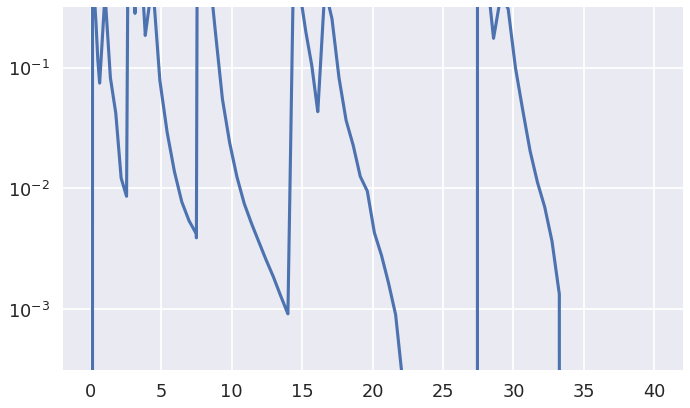

In [22]:
plt.plot(_df.time, _df.E_dot / 1e51)

plt.yscale("log")
plt.ylim(10**-3.5, 10**-.5)